In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling & evaluation
from sklearn.model_selection import train_test_split

# Visualization (optional)
import seaborn as sns
from wordcloud import WordCloud


 **Data Gathering**

In [2]:
df = pd.read_csv("fake_job_postings.csv")
df  # adjust path if necessary


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [3]:
df.shape

(17880, 18)

In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [5]:
df.describe() 

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.head() 

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [7]:
df.isnull().sum() 

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

**DATA PREPROCESSING**

In [8]:
text_columns = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("unknown")

In [9]:
df = df.dropna(subset=['fraudulent'])
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,unknown,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",unknown,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,unknown,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",unknown,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",unknown,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,unknown,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",unknown,NaN,unknown,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [10]:
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].str.lower()

In [11]:
columns = ['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for colu in columns:
    if colu in df.columns:
        del df[colu]
df.head() 

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,marketing intern,"us, ny, new york",marketing,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,unknown,Internship,NaN,NaN,Marketing,0
1,customer service - cloud video production,"nz, , auckland",success,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,commissioning machinery assistant (cma),"us, ia, wever",unknown,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,unknown,NaN,NaN,NaN,NaN,0
3,account executive - washington dc,"us, dc, washington",sales,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,bill review manager,"us, fl, fort worth",unknown,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


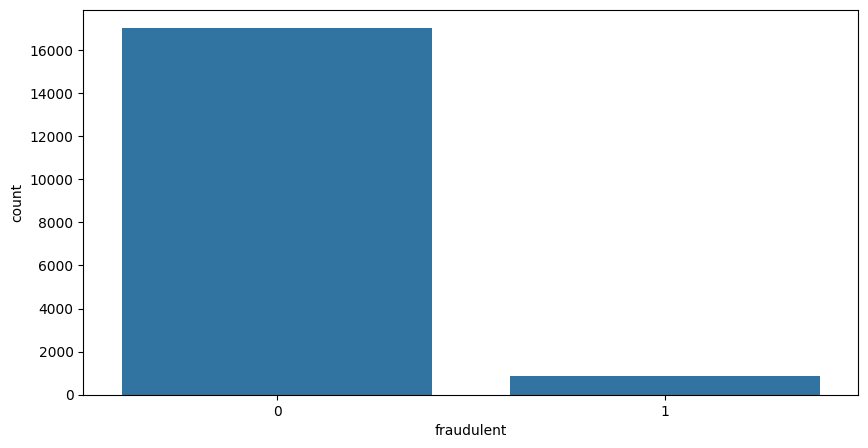

In [12]:
df.fillna('',inplace=True)
plt.figure(figsize=(10,5))
sns.countplot(x='fraudulent', data=df)
plt.show()

In [13]:
df.groupby('fraudulent')['fraudulent'].count() 

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [14]:
exp = dict(df.required_experience.value_counts())
del exp['']

exp

{'Mid-Senior level': np.int64(3809),
 'Entry level': np.int64(2697),
 'Associate': np.int64(2297),
 'Not Applicable': np.int64(1116),
 'Director': np.int64(389),
 'Internship': np.int64(381),
 'Executive': np.int64(141)}

In [15]:
def split_country(location):
    if not isinstance(location, str) or not location.strip():
        return ""
    parts = [p.strip() for p in location.split(',') if p.strip()]
    # take last piece assuming format like "City, State, Country"
    return parts[-1] if parts else ""

df['country'] = df.location.apply(split_country)
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,marketing intern,"us, ny, new york",marketing,"we're food52, and we've created a groundbreaki...","food52, a fast-growing, james beard award-winn...",experience with content management systems a m...,unknown,Internship,,,Marketing,0,new york
1,customer service - cloud video production,"nz, , auckland",success,"90 seconds, the worlds cloud video production ...",organised - focused - vibrant - awesome!do you...,what we expect from you:your key responsibilit...,what you will get from usthrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,auckland
2,commissioning machinery assistant (cma),"us, ia, wever",unknown,valor services provides workforce solutions th...,"our client, located in houston, is actively se...",implement pre-commissioning and commissioning ...,unknown,,,,,0,wever
3,account executive - washington dc,"us, dc, washington",sales,our passion for improving quality of life thro...,the company: esri – environmental systems rese...,"education: bachelor’s or master’s in gis, busi...",our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,washington
4,bill review manager,"us, fl, fort worth",unknown,spotsource solutions llc is a global human cap...,job title: itemization review managerlocation:...,qualifications:rn license in the state of texa...,full benefits offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,fort worth


Top countries: {'london': np.int64(1118), 'new york': np.int64(699), 'athens': np.int64(570), 'san francisco': np.int64(493), 'us': np.int64(403), 'unknown': np.int64(346), 'houston': np.int64(280), 'chicago': np.int64(275), 'berlin': np.int64(264), 'washington': np.int64(259), 'auckland': np.int64(235), 'los angeles': np.int64(203), 'austin': np.int64(196), 'san diego': np.int64(173)}


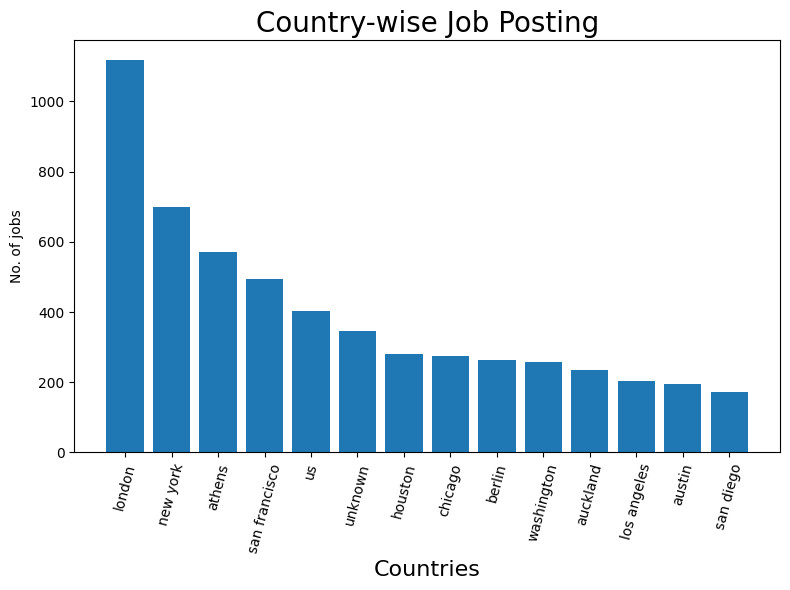

In [16]:
countr = dict(df.country.value_counts()[:14])
print("Top countries:", countr)
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(countr.keys(), countr.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=16)
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [17]:
edu = dict(df.required_education.value_counts()[:7])
if '' in edu:
    del edu['']  # remove empty placeholder
print("Required education counts (non-empty):", edu)

Required education counts (non-empty): {"Bachelor's Degree": np.int64(5145), 'High School or equivalent': np.int64(2080), 'Unspecified': np.int64(1397), "Master's Degree": np.int64(416), 'Associate Degree': np.int64(274), 'Certification': np.int64(170)}


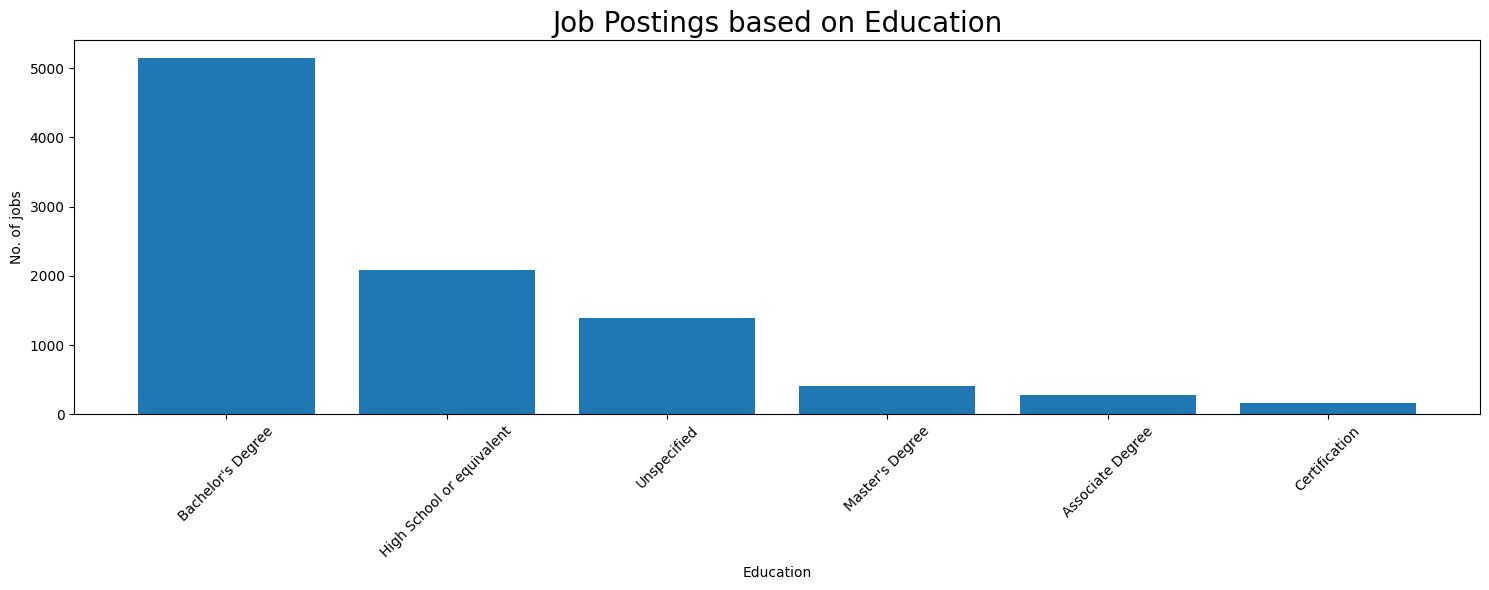

In [18]:
plt.figure(figsize=(15,6))
plt.title('Job Postings based on Education', size=20)
plt.bar(edu.keys(), edu.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Education', size=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
print("Top titles for real postings (fraudulent==0):")
print(df[df.fraudulent == 0].title.value_counts()[:10])


Top titles for real postings (fraudulent==0):
title
english teacher abroad                                311
customer service associate                            146
graduates: english teacher abroad (conversational)    144
english teacher abroad                                 95
software engineer                                      88
english teacher abroad (conversational)                83
customer service associate - part time                 76
account manager                                        74
web developer                                          70
project manager                                        66
Name: count, dtype: int64


In [20]:
print("\nTop titles for fake postings (fraudulent==1):")
print(df[df.fraudulent == 1].title.value_counts()[:10])


Top titles for fake postings (fraudulent==1):
title
cruise staff wanted *urgent*                                            21
data entry admin/clerical positions - work from home                    21
home based payroll typist/data entry clerks positions available         21
administrative assistant                                                19
customer service representative                                         19
home based payroll data entry clerk position - earn $100-$200 daily     12
data entry                                                              11
payroll clerk                                                           10
account sales managers $80-$130,000/yr                                  10
payroll data coordinator positions - earn $100-$200 daily               10
Name: count, dtype: int64


In [21]:
df['text']=df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [22]:
df.head()

,fraudulent,text
0,0,"marketing intern we're food52, and we've creat..."
1,0,customer service - cloud video production 90 s...
2,0,commissioning machinery assistant (cma) valor ...
3,0,account executive - washington dc our passion ...
4,0,bill review manager spotsource solutions llc i...


**Feature extraction**

In [23]:
pip install spacy && python -m spacy download en

Defaulting to user installation because normal site-packages is not writeable
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 3.8 MB/s eta 0:00:04
     ------- -------------------------------- 2.4/12.8 MB 5.8 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 6.2 MB/s eta 0:00:02
     --------------- ------------------------ 5.0/12.8 MB 6.0 MB/s eta 0:00:02
     ------------------- -------------------- 6.3/12.8 MB 6.1 MB/s eta 0:00:02
     ------------------------ --------------- 7.9/12.8 MB 6.2 MB/s eta 0:00:01
     ---------------------------- ----------- 9.2/12.8 MB 6.3 MB/s eta 0:00:01
     --------------------------------- ------ 10.7/12.8 MB 6.3 MB/s eta 0:00:01
     ----------

In [24]:
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Stop words and punctuations
stop_words = STOP_WORDS
punctuations = string.punctuation


In [25]:
# ----------------------
# 📌 Clean text function
# ----------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"\@\w+|\#", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [26]:
# ----------------------
# 📌 Apply cleaning
# ----------------------
df['text'] = df['text'].apply(clean_text)


# ----------------------
# 📌 Extra Simple NLP Preprocessing (new additions)
# ----------------------



# 1. Remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['text'] = df['text'].apply(remove_stopwords)


# 2. Remove extra spaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# 3. Additional simple feature: average word length
df['avg_word_len'] = df['text'].apply(
    lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
)


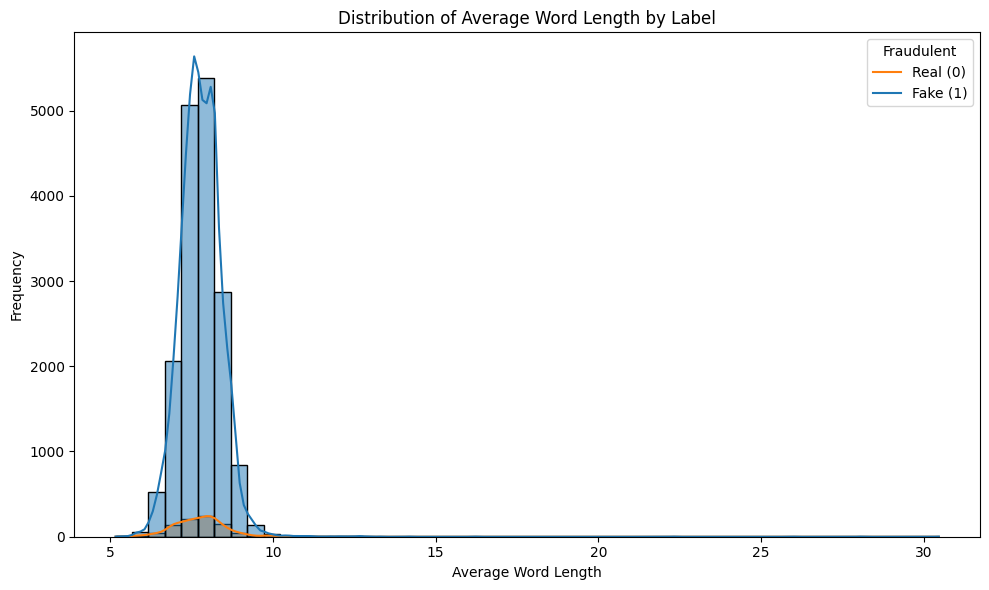

In [27]:
# ----------------------
# 📊  Avg Word Length Distribution
# ----------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='avg_word_len', hue='fraudulent', bins=50, kde=True)
plt.title("Distribution of Average Word Length by Label")
plt.xlabel("Average Word Length")
plt.ylabel("Frequency")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

In [28]:
# Add character count and word count features
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))

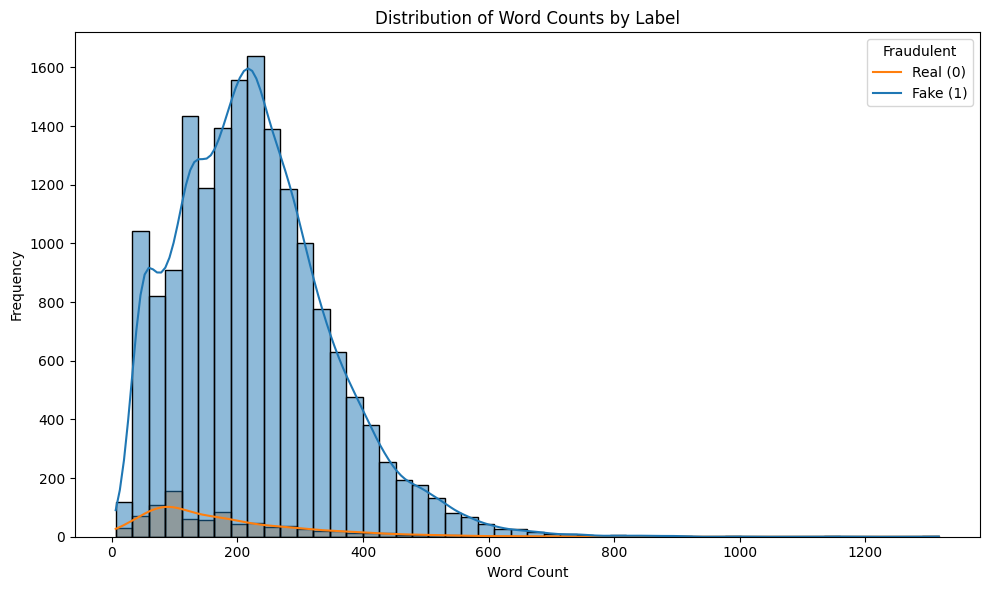

In [29]:
# =======================
# 📊 PLOTTING
# =======================

# Word Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='fraudulent', bins=50, kde=True)
plt.title("Distribution of Word Counts by Label")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()

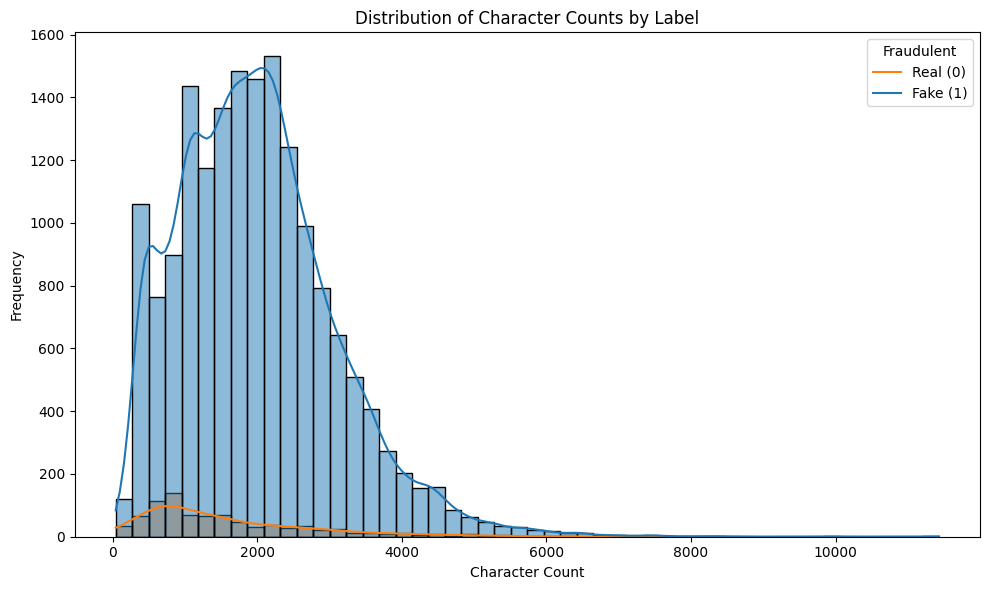

In [30]:
# Character Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='char_count', hue='fraudulent', bins=50, kde=True)
plt.title("Distribution of Character Counts by Label")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.legend(title='Fraudulent', labels=['Real (0)', 'Fake (1)'])
plt.tight_layout()
plt.show()


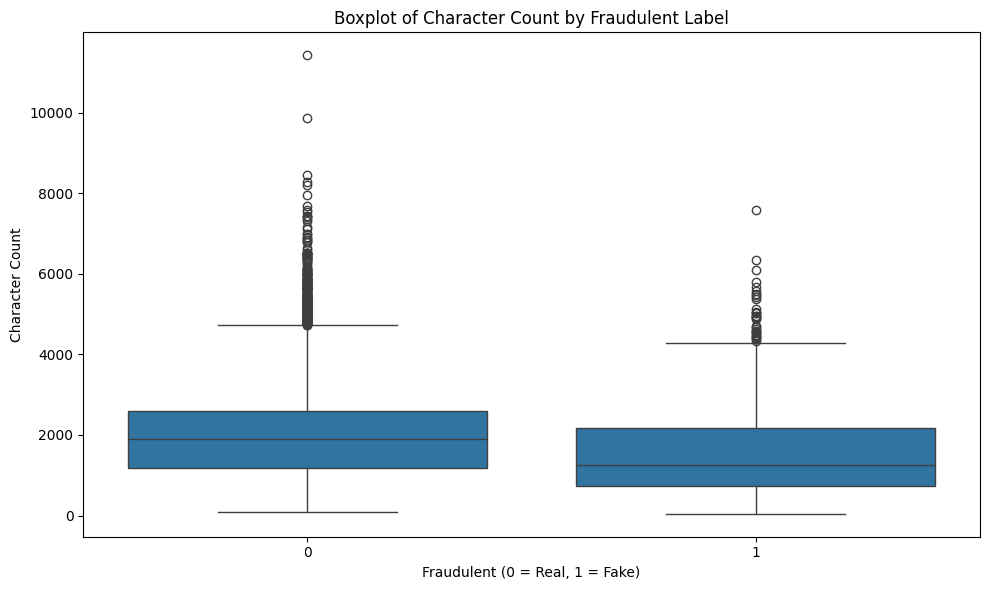

In [31]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraudulent', y='char_count', data=df)
plt.title("Boxplot of Character Count by Fraudulent Label")
plt.xlabel("Fraudulent (0 = Real, 1 = Fake)")
plt.ylabel("Character Count")
plt.tight_layout()
plt.show()


In [32]:
# %%
# ----------------------
# 📌 TF-IDF Vectorization
# ----------------------
tfidf = TfidfVectorizer(stop_words='english', max_features=100)
X_tfidf = tfidf.fit_transform(df['text'])

# Convert to DataFrame
X_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Combine with label
final_df = pd.concat([X_df, df[['fraudulent']].reset_index(drop=True)], axis=1)

**TRAIN / TEST SPLIT**

In [33]:
X = final_df.drop('fraudulent', axis=1)
y = final_df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**MODEL TRAINING**

In [34]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

------ SVM ------
⏱️ Training Time: 4.80 seconds
Accuracy: 0.97110365398956
📊 Cross-Validation Accuracy: 0.9689
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      5093
           1       1.00      0.43      0.60       271

    accuracy                           0.97      5364
   macro avg       0.99      0.71      0.79      5364
weighted avg       0.97      0.97      0.97      5364

Confusion Matrix:
 [[5093    0]
 [ 155  116]]


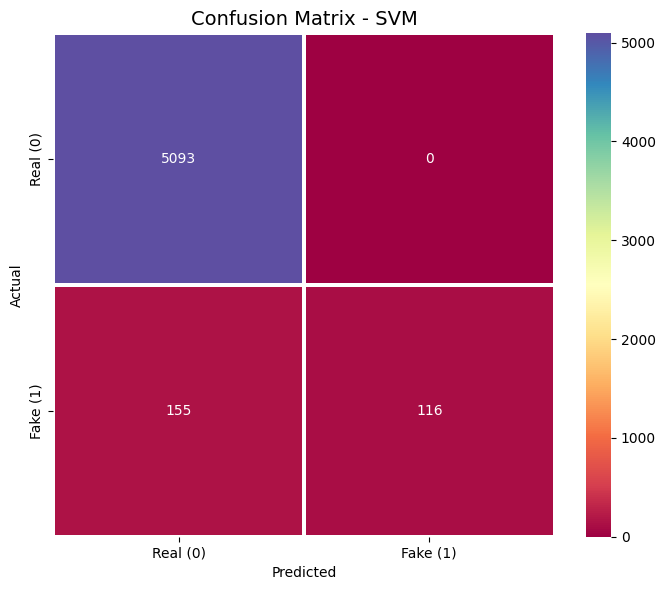

In [35]:
# =========================
# SVM
# =========================
start_time = time.time()
svm = SVC()
svm.fit(X_train, y_train)
end_time = time.time()
svm_time = end_time - start_time

svm_pred = svm.predict(X_test)
svm_cv = cross_val_score(SVC(), X, y, cv=5).mean()

print("------ SVM ------")
print(f"⏱️ Training Time: {svm_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(f"📊 Cross-Validation Accuracy: {svm_cv:.4f}")
print("Classification Report:\n", classification_report(y_test, svm_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))

cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral', linewidths=1.5, linecolor='white',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.title('Confusion Matrix - SVM', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


------ Extra Trees Classifier ------
⏱️ Training Time: 3.29 seconds
Accuracy: 0.9733407904548844
📊 Cross-Validation Accuracy: 0.9725
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      5093
           1       1.00      0.47      0.64       271

    accuracy                           0.97      5364
   macro avg       0.99      0.74      0.81      5364
weighted avg       0.97      0.97      0.97      5364

Confusion Matrix:
 [[5093    0]
 [ 143  128]]


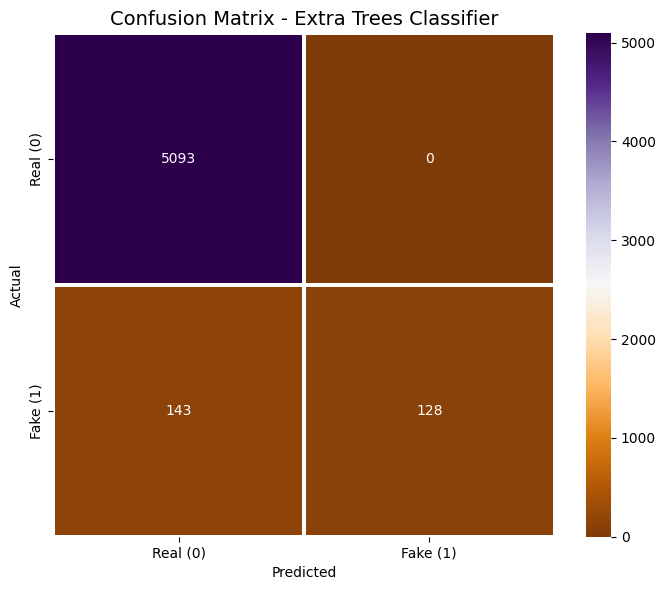

In [36]:


# =========================
# Extra Trees Classifier
# =========================
start_time = time.time()
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
end_time = time.time()
etc_time = end_time - start_time

etc_pred = etc.predict(X_test)
etc_cv = cross_val_score(ExtraTreesClassifier(), X, y, cv=5).mean()

print("------ Extra Trees Classifier ------")
print(f"⏱️ Training Time: {etc_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, etc_pred))
print(f"📊 Cross-Validation Accuracy: {etc_cv:.4f}")
print("Classification Report:\n", classification_report(y_test, etc_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, etc_pred))

cm = confusion_matrix(y_test, etc_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuOr', linewidths=1.5, linecolor='white',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.title('Confusion Matrix - Extra Trees Classifier', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:32:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:32:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:32:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:32:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

------ XGBoost ------
⏱️ Training Time: 2.38 seconds
Accuracy: 0.9740865026099925
📊 Cross-Validation Accuracy: 0.9715
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5093
           1       0.91      0.54      0.68       271

    accuracy                           0.97      5364
   macro avg       0.94      0.77      0.83      5364
weighted avg       0.97      0.97      0.97      5364

Confusion Matrix:
 [[5079   14]
 [ 125  146]]


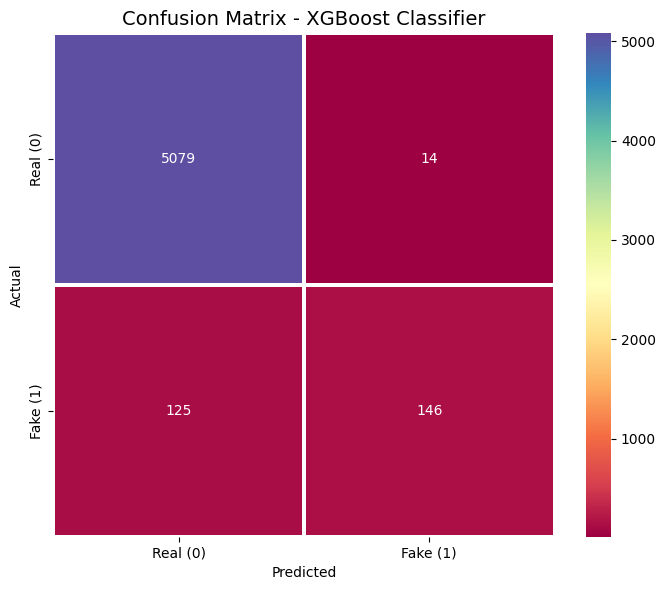

In [37]:


# =========================
# XGBoost Classifier
# =========================
start_time = time.time()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
end_time = time.time()
xgb_time = end_time - start_time

xgb_pred = xgb.predict(X_test)
xgb_cv = cross_val_score(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X, y, cv=5).mean()

print("------ XGBoost ------")
print(f"⏱️ Training Time: {xgb_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print(f"📊 Cross-Validation Accuracy: {xgb_cv:.4f}")
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

cm = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral', linewidths=1.5, linecolor='white',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier', fontsize=14)
plt.tight_layout()
plt.show()



------ Passive Aggressive ------
⏱️ Training Time: 0.08 seconds
Accuracy: 0.912751677852349
📊 Cross-Validation Accuracy: 0.9416
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      5093
           1       0.29      0.51      0.37       271

    accuracy                           0.91      5364
   macro avg       0.63      0.72      0.66      5364
weighted avg       0.94      0.91      0.92      5364

Confusion Matrix:
 [[4757  336]
 [ 132  139]]


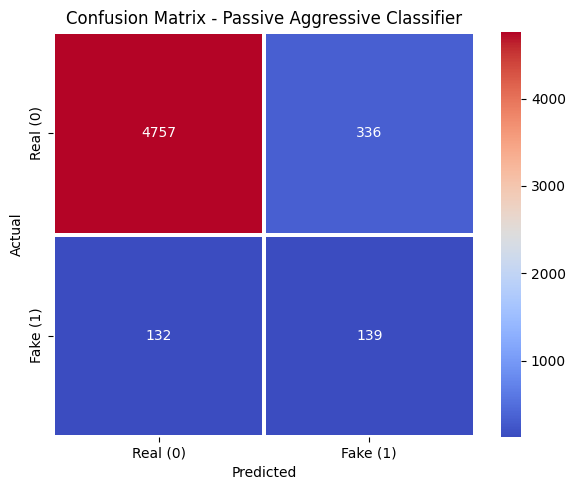

In [38]:

# =========================
# Passive Aggressive Classifier
# =========================
start_time = time.time()
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
end_time = time.time()
pac_time = end_time - start_time

pac_pred = pac.predict(X_test)
pac_cv = cross_val_score(PassiveAggressiveClassifier(), X, y, cv=5).mean()

print("------ Passive Aggressive ------")
print(f"⏱️ Training Time: {pac_time:.2f} seconds")
print("Accuracy:", accuracy_score(y_test, pac_pred))
print(f"📊 Cross-Validation Accuracy: {pac_cv:.4f}")
print("Classification Report:\n", classification_report(y_test, pac_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pac_pred))

cm = confusion_matrix(y_test, pac_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=1.5, linecolor='white',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.tight_layout()
plt.show()

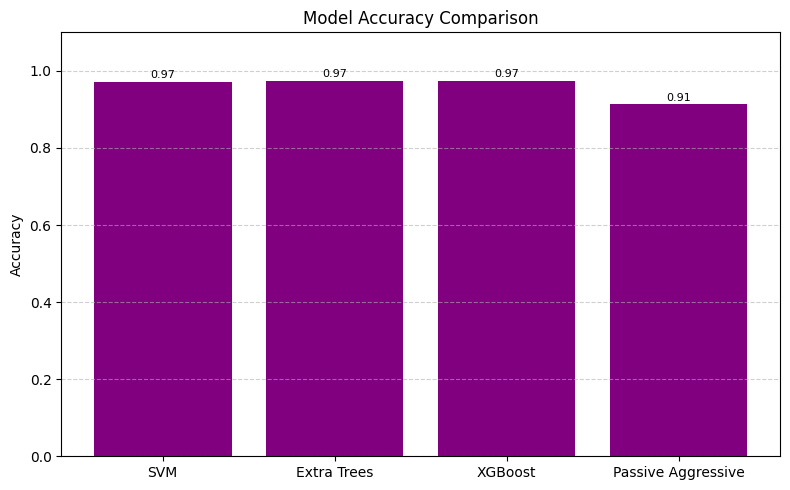

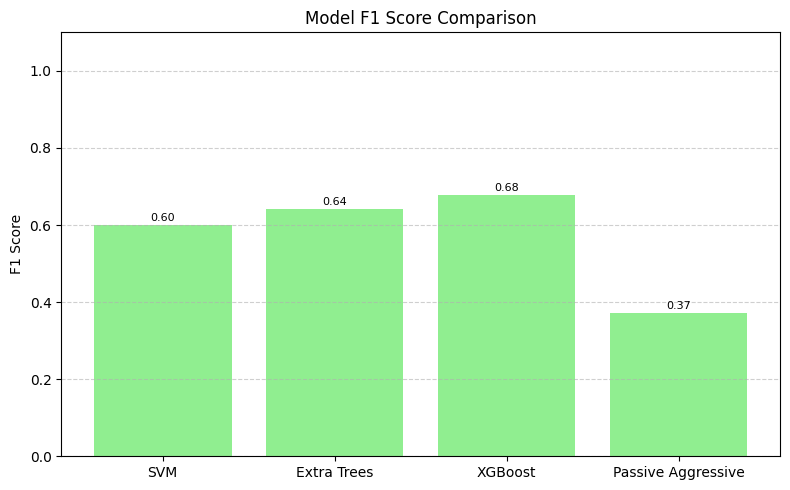

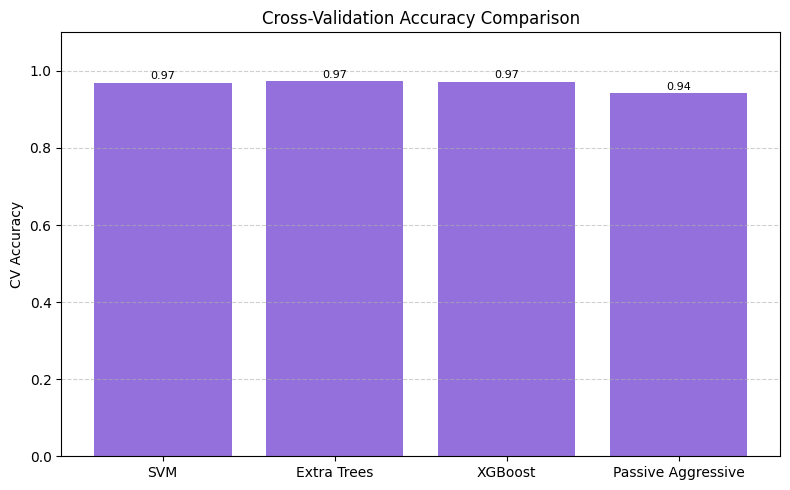

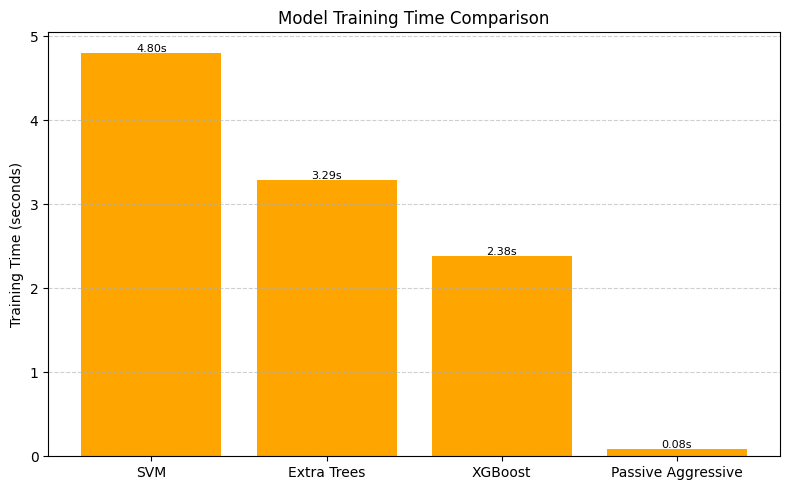

In [39]:
# =========================
# Final Comparison Plots (Separated)
# =========================
model_names = ["SVM", "Extra Trees", "XGBoost", "Passive Aggressive"]

accuracies = [
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, etc_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, pac_pred)
]

f1_scores = [
    f1_score(y_test, svm_pred),
    f1_score(y_test, etc_pred),
    f1_score(y_test, xgb_pred),
    f1_score(y_test, pac_pred)
]

cv_scores = [svm_cv, etc_cv, xgb_cv, pac_cv]
train_times = [svm_time, etc_time, xgb_time, pac_time]

# ----- Accuracy -----
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, accuracies, color='purple')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}", ha="center", fontsize=8)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----- F1 Score -----
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, f1_scores, color='lightgreen')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}", ha="center", fontsize=8)
plt.ylabel("F1 Score")
plt.title("Model F1 Score Comparison")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Cross-Validation Accuracy -----
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, cv_scores, color='mediumpurple')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}", ha="center", fontsize=8)
plt.ylabel("CV Accuracy")
plt.title("Cross-Validation Accuracy Comparison")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# ----- Training Time -----
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, train_times, color='orange')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.01,
             f"{bar.get_height():.2f}s", ha="center", fontsize=8)
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()








In [40]:
import pandas as pd

# ================================
# Model Names & Evaluation Metrics
# ================================
model_names = ["SVM", "Extra Trees", "XGBoost", "Passive Aggressive"]

accuracies = [
    accuracy_score(y_test, svm_pred),
    accuracy_score(y_test, etc_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, pac_pred)
]

f1_scores = [
    f1_score(y_test, svm_pred),
    f1_score(y_test, etc_pred),
    f1_score(y_test, xgb_pred),
    f1_score(y_test, pac_pred)
]

cv_scores = [svm_cv, etc_cv, xgb_cv, pac_cv]
train_times = [svm_time, etc_time, xgb_time, pac_time]

# =================================
# Create DataFrame for Comparison
# =================================
results_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "F1-Score": f1_scores,
    "CV Accuracy": cv_scores,
    "Training Time (s)": train_times
})

# ================================
# Ranking Models 
# (Higher is Better for Accuracy, F1, CV — Lower is Better for Training Time)
# ================================
rank_df = results_df.copy()

rank_df["Accuracy"] = rank_df["Accuracy"].rank(method='min', ascending=False)
rank_df["F1-Score"] = rank_df["F1-Score"].rank(method='min', ascending=False)
rank_df["CV Accuracy"] = rank_df["CV Accuracy"].rank(method='min', ascending=False)
rank_df["Training Time (s)"] = rank_df["Training Time (s)"].rank(method='min', ascending=True)  # lower is better

# Average Rank
results_df["Avg Rank"] = rank_df[["Accuracy", "F1-Score", "CV Accuracy", "Training Time (s)"]].mean(axis=1)

# Sort by Average Rank
final_rankings = results_df.sort_values(by="Avg Rank")

# ================================
# Print Best Model
# ================================
best_model = final_rankings.iloc[0]["Model"]

print("📊 Model Performance Comparison:\n")
print(results_df)
print("\n🏆 Best Model Overall:", best_model)
print("\n📌 Final Rankings (Best → Worst):")
print(final_rankings[["Model", "Avg Rank"]])


📊 Model Performance Comparison:

                Model  Accuracy  F1-Score  CV Accuracy  Training Time (s)  \
0                 SVM  0.971104  0.599483     0.968904           4.804454   
1         Extra Trees  0.973341  0.641604     0.972483           3.287137   
2             XGBoost  0.974087  0.677494     0.971532           2.384459   
3  Passive Aggressive  0.912752  0.372654     0.941555           0.083727   

   Avg Rank  
0      3.25  
1      2.00  
2      1.50  
3      3.25  

🏆 Best Model Overall: XGBoost

📌 Final Rankings (Best → Worst):
                Model  Avg Rank
2             XGBoost      1.50
1         Extra Trees      2.00
0                 SVM      3.25
3  Passive Aggressive      3.25


C:\Users\admin\AppData\Local\Temp\ipykernel_564\4175954371.py:31: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\admin\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


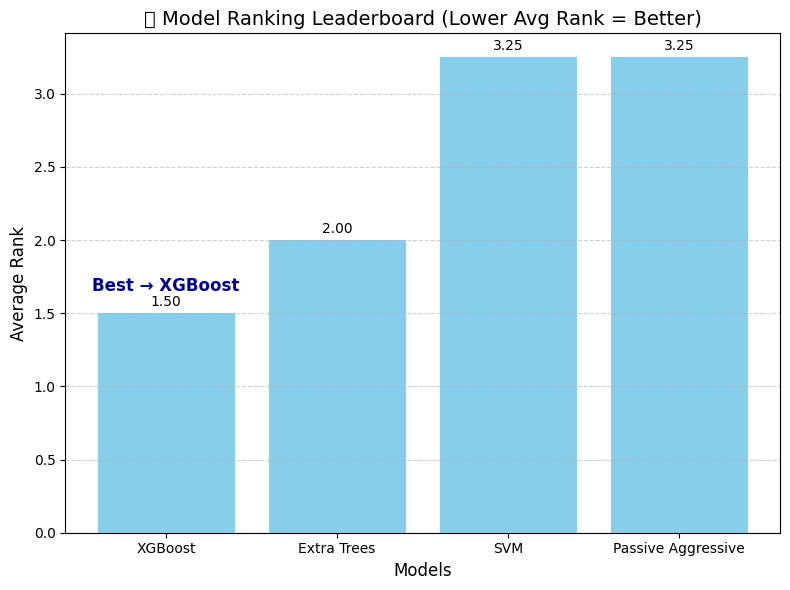

In [41]:
import matplotlib.pyplot as plt

# ================================
# Leaderboard Visualization (Vertical, Sorted Best → Worst)
# ================================
sorted_rankings = final_rankings.sort_values(by="Avg Rank")  # ensure sorted

plt.figure(figsize=(8,6))
bars = plt.bar(sorted_rankings["Model"], sorted_rankings["Avg Rank"], color="skyblue")

plt.title("🏆 Model Ranking Leaderboard (Lower Avg Rank = Better)", fontsize=14)
plt.ylabel("Average Rank", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Highlight best model
best_model_name = sorted_rankings.iloc[0]["Model"]
best_rank = sorted_rankings.iloc[0]["Avg Rank"]

# Add value labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f"{bar.get_height():.2f}", ha="center", fontsize=10)

# Add label for best model
plt.text(bars[0].get_x() + bars[0].get_width()/2, 
         bars[0].get_height() + 0.15,
         f"Best → {best_model_name}", 
         ha="center", fontsize=12, color="darkblue", fontweight="bold")

plt.tight_layout()
plt.show()




In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveClassifier  # fast model

# Load dataset
df = pd.read_csv("fake_job_postings.csv")

# Sample only 3000 rows for speed
df = df.sample(3000, random_state=42)

# Combine text columns
df["text"] = (
    df["title"].astype(str) + " " +
    df["location"].astype(str) + " " +
    df["department"].astype(str) + " " +
    df["salary_range"].astype(str) + " " +
    df["company_profile"].astype(str) + " " +
    df["description"].astype(str) + " " +
    df["requirements"].astype(str) + " " +
    df["benefits"].astype(str)
)

X = df["text"]
y = df["fraudulent"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a fast pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=2000)),  # smaller features
    ("clf", PassiveAggressiveClassifier(max_iter=500, random_state=42))
])

# Train
pipeline.fit(X_train, y_train)
acc = pipeline.score(X_test, y_test)
print(f"✅ Fast model trained - Accuracy: {acc:.4f}")

# Save
joblib.dump(pipeline, "fast_model.pkl")
print("💾 Model saved as fast_model.pkl")




✅ Fast model trained - Accuracy: 0.9717
💾 Model saved as fast_model.pkl
